# Bayesian mixture models

[Mixture models](mixture_models.ipynb) introduced how to infer the local optima for the parameters of a mixture model.
Here we will treat the parameters are random variables and place prior distributions over them. We will infer those parameters using *collapsed Gibbs sampling*.

**As usual I do not take warranty for the correctness or completeness of this document.**

We shall use conjugate priors for means and covariances (Normal-Inverse-Wishart), such that we can use a collapsed Gibbs sampler (i.e. we integrate the parameters out):

\begin{align*}
\boldsymbol  \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol  \mu_k  & \sim \mathcal{N}(\boldsymbol \mu_0, \sigma^2_0 \mathbf{I})\\
\boldsymbol \pi &  \sim \text{Dirichlet}(1.0,\dots, 1.0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim \mathcal{N}(\boldsymbol \mu_k, \boldsymbol \Sigma_k).\end{align*}

In [11]:
options(repr.fig.width=4, repr.plot.height=3)

In [47]:
library("e1071")
library("mvtnorm")
library("dplyr")
set.seed(23)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [13]:
n <- 100
p <- 2
sigma <- .5 * diag(p)
mus <- matrix(c(0, 5, 10, 0, 5, 10), ncol = 2)

In [14]:
Z <- sample(1:3, 100, TRUE)
X <- matrix(0, n, 2)
for (i in seq(3)) {
    X[Z == i, ] <- mvtnorm::rmvnorm(sum(Z == i), mus[i,], sigma)   
}

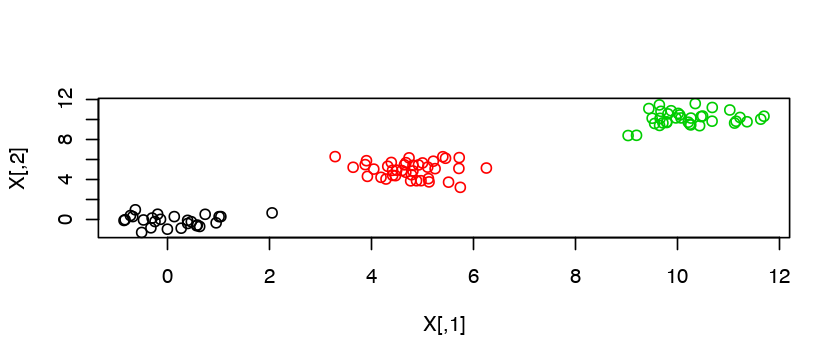

In [15]:
plot(X, col=Z)

In [17]:
m0 <- rep(0, p)
Sigma0 <- diag(p)

In [57]:
mvt <- function(X=NULL, skip=FALSE)
{    
    kn <- 2
    nun <- 2
    if (!skip) {
        X.bar <- apply(X, 2, mean, na.rm=TRUE)
        n <- nrow(X)
        kn <- kn + n
        nun <- nun + n
        mn <- (m0 + n * X.bar) / kn
        Sn <- Sigma0 + t(X) %*% X + m0 %*% t(m0) #- mn %*% t(mn)
    } else {
        X.bar <- rep(0, p)    
        n <- 0
        mn <- m0
        Sn <- Sigma0
    }
}

In [58]:
alpha <- 1

In [61]:
# initialization of the cluster assignments
Z <- sample(1:3, n, replace = TRUE)
# customers per table
tables <- rmultinom(n = 1, size = 100, prob = c(1, 1, 1))
# number.of.clusters
K <- 3

for (iter in seq(10))
{
   for (i in seq(n))
   {
        zi <- Z[i]
        tables[zi] <- tables[zi] - 1
    
        # compute posterior probabilitites for joining a table
        no_i <- seq(n)[-i]
        p_zi <- sapply(seq(K), function(k) {
            # prior P(z_i | z_-i)
            pz <- (tables[k] - 1 + alpha / K) / (n + alpha - 1)
            # compute likelihood P(x_i | x_-i)
            lik <- mvt(X[Z[no_i] == k, , drop=FALSE])
            # posterior up to normalization
            pz * lik
        })
        p_zi <- p_zi / sum(p_zi)
           
        # sample new Z
        z_new <- rdiscrete(1, probs = p_zi)
        Z[i] <- z_new        
        tables[z_new] <- tables[z_new] + 1
    }
}

ERROR: Error in sample.int(length(x), size, replace, prob): negative probability


In [ ]:
plot(X, col=Z)

In [1]:
library(greta)


Attaching package: ‘greta’

The following objects are masked from ‘package:stats’:

    binomial, cov2cor, poisson

The following objects are masked from ‘package:base’:

    %*%, apply, backsolve, beta, chol2inv, colMeans, colSums, diag,
    eigen, forwardsolve, gamma, identity, rowMeans, rowSums, sweep,
    tapply



In [9]:
data {
 int<lower = 0> N;
 vector[N] y;
}

parameters {
  ordered[2] mu;
  real<lower=0> saigma[2];
  real<lower=0, upper=1> theta;
}

model {
 sigma ~ normal(0, 2);
 mu ~ normal(0, 2);
 theta ~ beta(5, 5);
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): UnboundLocalError: local variable 'a' referenced before assignment

Detailed traceback: 
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py", line 240, in sample_chain
    previous_kernel_results = kernel.bootstrap_results(current_state)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py", line 508, in bootstrap_results
    kernel_results = self._impl.bootstrap_results(init_state)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py", line 270, in bootstrap_results
    is_accepted=tf.ones_like(x, dtype=tf.bool),
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1651, in ones_like
    ret = ones(ones_shape, dtype=dtype, name=name)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1698, in ones
    output = fill(shape, constant(one, dtype=dtype), name=name)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 207, in constant
    value, dtype=dtype, shape=shape, verify_shape=verify_shape))
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py", line 542, in make_tensor_proto
    append_fn(tensor_proto, proto_values)
  File "tensorflow/python/framework/fast_tensor_util.pyx", line 134, in tensorflow.python.framework.fast_tensor_util.AppendBoolArrayToTensorProto
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/numpy/lib/type_check.py", line 489, in asscalar
    return a.item()



greta array (variable following a mixture distribution)

     [,1]
[1,]  ?  

In [6]:
m <- model(a)

In [7]:
plot(mcmc(m, n_samples = 500))

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): UnboundLocalError: local variable 'a' referenced before assignment

Detailed traceback: 
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py", line 240, in sample_chain
    previous_kernel_results = kernel.bootstrap_results(current_state)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py", line 508, in bootstrap_results
    kernel_results = self._impl.bootstrap_results(init_state)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py", line 270, in bootstrap_results
    is_accepted=tf.ones_like(x, dtype=tf.bool),
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1651, in ones_like
    ret = ones(ones_shape, dtype=dtype, name=name)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1698, in ones
    output = fill(shape, constant(one, dtype=dtype), name=name)
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 207, in constant
    value, dtype=dtype, shape=shape, verify_shape=verify_shape))
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py", line 542, in make_tensor_proto
    append_fn(tensor_proto, proto_values)
  File "tensorflow/python/framework/fast_tensor_util.pyx", line 134, in tensorflow.python.framework.fast_tensor_util.AppendBoolArrayToTensorProto
  File "/Users/simondi/miniconda3/envs/r-tensorflow/lib/python3.7/site-packages/numpy/lib/type_check.py", line 489, in asscalar
    return a.item()



In [ ]:


# simulate a mixture of poisson random variables and try to recover the
# parameters with a Bayesian model
x <- c(rpois(800, 3),
       rpois(200, 10))

weights <- uniform(0, 1, dim = 2)
rates <- normal(0, 10, truncation = c(0, Inf), dim = 2)
distribution(x) <- mixture(poisson(rates[1]),
                           poisson(rates[2]),
                           weights = weights)
m <- model(rates)
draws_rates <- mcmc(m, n_samples = 500)

# check the mixing probabilities after fitting using calculate()
# (you could also do this within the model)
normalized_weights <- weights / sum(weights)
draws_weights <- calculate(normalized_weights, draws_rates)

# get the posterior means
summary(draws_rates)$statistics[, "Mean"]
summary(draws_weights)$statistics[, "Mean"]

# weights can also be an array, giving different mixing weights
# for each observation (first dimension must be number of components)
dim <- c(5, 4)
weights <- uniform(0, 1, dim = c(2, dim))
b <- mixture(normal(1, 1, dim = dim),
             normal(-1, 1, dim = dim),
             weights = weights)